In [1]:
from SimPEG import Mesh, Utils, EM, Maps
from pymatsolver import Pardiso
from scipy.constants import mu_0
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pyMKL import mkl_set_num_threads
from multiprocessing import Pool
from SimPEG import Mesh
import pandas as pd

from pathlib import Path
import pandas as pd
import fileinput
# import cartopy

In [2]:
datadir = Path('../data/raw_data')
data17dir = datadir.joinpath('AEM_data_2017_avg')
data19dir = datadir.joinpath('AEM_data_2019_avg')

data17 = datadir.joinpath('AEM_data_2017','MCWD3_SCI1i_MOD_dat.xyz')
data19 = datadir.joinpath('AEM_data_2019','MCWD19_SCI8i_MOD_dat.xyz')

In [3]:
def rm_leadspace(f_name):
    for line in fileinput.input(f_name,inplace = True):
        if line.startswith('/ '):
            print(line.lstrip('/ ').rstrip('\n'))
        else:
            print(line.rstrip('\n'))
    fileinput.close()
    
xyz_dirs = (data17.parent,data19.parent,data17dir,data19dir)

for d in xyz_dirs:
    for f in d.iterdir():
        if f.as_posix().endswith('xyz'):
            rm_leadspace(f.as_posix())

In [19]:
df17 = pd.read_csv(data17,header=20,delim_whitespace=True)
df19 = pd.read_csv(data19,header=20,delim_whitespace=True)

df17 = df17.assign(skytem_type=304)
df19 = df19.assign(skytem_type=312)
# df1719 = pd.concat((df17,df19))

header=20
flag=0
for i,f in enumerate(data17dir.iterdir()):
    if flag==0:
        df = pd.read_csv(f,header=header,delim_whitespace=True)
        df = df.assign(FLIGHT_NO=f.name.split('_')[0])
        df = df.assign(skytem_type=304)
        flag=1
    else:
        df_temp = pd.read_csv(f,header=header,delim_whitespace=True)
        df_temp = df_temp.assign(FLIGHT_NO=f.name.split('_')[0])
        df_temp = df_temp.assign(skytem_type=304)
        df = pd.concat((df,df_temp))

for f in data19dir.iterdir():
    df_temp = pd.read_csv(f,header=header,delim_whitespace=True)
    df_temp = df_temp.assign(FLIGHT_NO=f.name.split('_')[0])
    df_temp = df_temp.assign(skytem_type=312)
    df = pd.concat((df,df_temp))

In [21]:
df = df.reset_index()
df = df.rename(columns={'index':'index_orig'})
df.index = df.index.astype(np.float)

In [22]:
i_start_hm = 10
i_start_lm = 10

lm_inds = np.array(['DBDT_Ch1' in key.split('GT') for key in df.keys()], dtype=bool)
hm_inds = np.array(['DBDT_Ch2' in key.split('GT') for key in df.keys()], dtype=bool)
dbdt_inds = np.array([key.startswith('DBDT') for key in df.keys()], dtype=bool)

lm_header = (df.keys()[lm_inds])[i_start_lm:]
hm_header = (df.keys()[hm_inds])[i_start_hm:]

#### Weave in blank HM soundings into repeated LM (and LM into repeated HM)

In [25]:
df.loc[10:20,:]

,index_orig,TIMESTAMP,LINE_NO,UTMX,UTMY,ELEVATION,CHANNEL_NO,RX_ALTITUDE,RX_ALTITUDE_STD,TX_ALTITUDE,...,DBDT_STD_Ch2GT30,DBDT_STD_Ch2GT31,DBDT_STD_Ch2GT32,DBDT_STD_Ch2GT33,DBDT_STD_Ch2GT34,DBDT_STD_Ch2GT35,DBDT_STD_Ch2GT36,DBDT_STD_Ch2GT37,FLIGHT_NO,skytem_type
10.0,10,42871.846863,211901,613051.7,4053973.4,57.70,1,85.97,0.041,84.11,...,9999.00000,9999.00000,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0000,0516FL2pr,304
11.0,11,42871.846863,211901,613051.7,4053973.4,57.70,2,84.63,0.043,82.78,...,0.05955,0.05905,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0000,0516FL2pr,304
12.0,12,42871.846892,211901,613067.2,4054012.7,53.18,2,86.30,0.038,84.42,...,0.05714,0.05810,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0000,0516FL2pr,304
13.0,13,42871.846892,211901,613067.2,4054012.7,53.18,1,88.23,0.036,86.34,...,9999.00000,9999.00000,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0000,0516FL2pr,304
14.0,14,42871.846921,211901,613083.7,4054052.5,48.93,1,85.16,0.042,83.22,...,9999.00000,9999.00000,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0000,0516FL2pr,304
15.0,15,42871.846921,211901,613083.7,4054052.5,48.93,2,85.34,0.041,83.39,...,0.05342,0.05508,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0000,0516FL2pr,304
16.0,16,42871.846950,211901,613102.4,4054092.3,49.28,2,83.14,0.043,81.25,...,0.04785,0.05296,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0000,0516FL2pr,304
17.0,17,42871.846950,211901,613102.4,4054092.3,49.28,1,82.07,0.040,80.12,...,9999.00000,9999.00000,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0000,0516FL2pr,304
18.0,18,42871.846979,211901,613122.0,4054131.3,49.08,2,77.47,0.044,75.62,...,0.04101,0.04621,9999.0,9999.0,9999.0,9999.0,9999.0,0.1386,0516FL2pr,304
19.0,19,42871.846979,211901,613122.0,4054131.3,49.08,1,77.43,0.042,75.64,...,9999.00000,9999.00000,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0000,0516FL2pr,304


In [26]:
flag=0

#Do this line-by-line
ind_counter=0
for line_tmp in df.LINE_NO.unique():
    #Do this line-by-line
    ind_counter=0
    # for line_tmp in df.LINE_NO.unique():

    #Extract data from each line
    df_tmp = df.loc[df.LINE_NO==line_tmp]

    #Drop entries where the line starts w/ LM  or ends w/ HM
    last_ind = df_tmp.index.max()
    first_ind = df_tmp.index.min()
    if df_tmp.loc[last_ind].CHANNEL_NO==2:
        row = df_tmp.loc[last_ind].copy()
        row.CHANNEL_NO = 1
        row.loc[dbdt_inds] = 9999
        df_tmp.loc[last_ind+.25] = row
    if df_tmp.loc[first_ind].CHANNEL_NO==1:
        row = df_tmp.loc[first_ind].copy()
        row.CHANNEL_NO = 2
        row.loc[dbdt_inds] = 9999
        df_tmp.loc[first_ind-.25] = row

    #Drop entries where LM or HM is repeated
    repeat_inds = df_tmp.index[df_tmp.CHANNEL_NO.diff()==0]
    repeat_channel = df.CHANNEL_NO.loc[repeat_inds].values
    new_channel = np.asarray([2 if v==1 else 1 for v in repeat_channel])
    repeat_info = df.loc[repeat_inds,:].copy()
    repeat_info.loc[:,dbdt_inds] = 9999
    repeat_info.loc[:,'CHANNEL_NO'] = new_channel

    #If HM or LM is repeated, weave in an empty (all 9999) sounding  
    ind_list = repeat_info.index.tolist()
    for i,ind in enumerate(repeat_info.index):
        ind_list[i] += -0.5
    repeat_info.index = ind_list

    df_tmp = df_tmp.drop(index=repeat_inds)
    df_tmp = df_tmp.sort_index()

    index_new = np.arange(ind_counter,len(df_tmp)+ind_counter)
    ind_counter+=len(df_tmp)
    df_tmp = df_tmp.reindex(index=index_new)
#     print(df_tmp.index.min(),df_tmp.index.max())

    #Stack df_tmp to create df_new
    if flag==0:
        df_new = df_tmp.copy()
        flag=1
    else:
        df_new = df_new.append(df_tmp)

# df = df_new.copy()
# df = df.set_index('TIMESTAMP').sort_index().reset_index()
# df = df.sort_index()


/home/users/ianpg/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [52]:
flag=0

#Do this line-by-line
ind_counter=0
for s in df.skytem_type.unique():
    for line_tmp in df.loc[df.skytem_type==s].LINE_NO.unique():
        print(s,line_tmp)
        df_tmp = df.loc[np.logical_and(df.LINE_NO==line_tmp,df.skytem_type==s)]
        repeat_inds = df_tmp.CHANNEL_NO.diff()==0
        repeat_channel = df_tmp.CHANNEL_NO.loc[repeat_inds].values
        new_channel = np.asarray([2 if v==1 else 1 for v in repeat_channel])
        repeat_info = df_tmp.loc[repeat_inds,:].copy()
        repeat_info.loc[:,dbdt_inds] = 9999
        repeat_info.loc[:,'CHANNEL_NO'] = new_channel

        #If HM or LM is repeated, weave in an empty (all 9999) sounding  
        ind_list = repeat_info.index.tolist()
        for i,ind in enumerate(repeat_info.index):
            ind_list[i] += -0.5
        repeat_info.index = ind_list

        #append the new info and sort
        df_tmp = df_tmp.append(repeat_info)
        df_tmp = df_tmp.sort_index()


        #Verify that line starts w/ LM  and ends w/ HM
        last_ind = df_tmp.index.max()
        first_ind = df_tmp.index.min()
        if df_tmp.loc[last_ind].CHANNEL_NO==1:
            row = df_tmp.loc[last_ind].copy()
            row.CHANNEL_NO = 2
            row.loc[dbdt_inds] = 9999
            df_tmp.loc[last_ind+.25] = row
        if df_tmp.loc[first_ind].CHANNEL_NO==2:
            row = df_tmp.loc[first_ind].copy()
            row.CHANNEL_NO = 1
            row.loc[dbdt_inds] = 9999
            df_tmp.loc[first_ind-.25] = row

        df_tmp = df_tmp.sort_index()
        index_new = np.arange(ind_counter,len(df_tmp)+ind_counter)
        ind_counter+=len(df_tmp)
        df_tmp.index = index_new

        #Stack df_tmp to create df_new
        if flag==0:
            df_new = df_tmp.copy()
            flag=1
        else:
            df_new = df_new.append(df_tmp)
            
df_new = df_new.sort_values(by=['skytem_type','LINE_NO','TIMESTAMP'])
df = df_new.copy()
df.drop(df.loc[df.LINE_NO==0].index, inplace=True)


304 211901
304 211701
304 211501
304 211201
304 210701
304 210401
304 210201
304 209901
304 209601
304 209301
304 209101
304 211402
304 0
304 211102
304 210902
304 210602
304 210302
304 210102
304 209801
304 209501
304 209502
304 209802
304 210101
304 210301
304 210601
304 210901
304 211101
304 211401
304 208901
304 208702
304 208502
304 208301
304 208001
304 207701
304 100801
304 100701
304 100501
304 100601
304 209102
304 208902
304 208701
304 208501
304 208401
304 208101
304 207801
304 207501
304 207201
304 207001
304 206701
304 206401
304 201101
304 201401
304 201701
304 202401
304 202701
304 202901
304 203101
304 203301
304 203601
304 203901
304 204201
304 204501
304 204801
304 205101
304 205301
304 205601
304 206101
304 206301
304 206601
304 206901
304 207101
304 207401
304 205901
304 205801
304 205501
304 205201
304 205001
304 204701
304 204401
304 204101
304 203801
304 200203
304 100301
304 200202
304 200301
304 100901
304 204901
304 204601
304 204301
304 204001
304 203701
304 

,index_orig,TIMESTAMP,LINE_NO,UTMX,UTMY,ELEVATION,CHANNEL_NO,RX_ALTITUDE,RX_ALTITUDE_STD,TX_ALTITUDE,...,DBDT_STD_Ch2GT30,DBDT_STD_Ch2GT31,DBDT_STD_Ch2GT32,DBDT_STD_Ch2GT33,DBDT_STD_Ch2GT34,DBDT_STD_Ch2GT35,DBDT_STD_Ch2GT36,DBDT_STD_Ch2GT37,FLIGHT_NO,skytem_type


In [58]:
df_new = df_new.sort_values(by=['skytem_type','LINE_NO','TIMESTAMP'])
df = df_new.copy()
df.drop(df.loc[df.LINE_NO==0].index, inplace=True)
df = df.reset_index(drop=True)

In [59]:
for s in df.skytem_type.unique():
    df_tmp = df.loc[df.skytem_type==s]
    for l in df_tmp.LINE_NO.unique():
        print(df_tmp.loc[df_tmp.LINE_NO==l,'skytem_type'].unique(),l, df_tmp.loc[df_tmp.LINE_NO==l,'CHANNEL_NO'].diff().unique())
        

[304] 100101 [nan  1. -1.]
[304] 100201 [nan  1. -1.]
[304] 100301 [nan  1. -1.]
[304] 100401 [nan  1. -1.]
[304] 100501 [nan  1. -1.]
[304] 100601 [nan  1. -1.]
[304] 100701 [nan  1. -1.]
[304] 100801 [nan  1. -1.]
[304] 100901 [nan  1. -1.]
[304] 200101 [nan  1. -1.]
[304] 200201 [nan  1. -1.]
[304] 200202 [nan  1. -1.]
[304] 200203 [nan  1. -1.]
[304] 200204 [nan  1. -1.]
[304] 200205 [nan  1. -1.]
[304] 200301 [nan  1. -1.]
[304] 200401 [nan  1. -1.]
[304] 200501 [nan  1. -1.]
[304] 200601 [nan  1. -1.]
[304] 200701 [nan  1. -1.]
[304] 200801 [nan  1. -1.]
[304] 200901 [nan  1. -1.]
[304] 201001 [nan  1. -1.]
[304] 201101 [nan  1. -1.]
[304] 201201 [nan  1. -1.]
[304] 201301 [nan  1. -1.]
[304] 201401 [nan  1. -1.]
[304] 201501 [nan  1. -1.]
[304] 201601 [nan  1. -1.]
[304] 201701 [nan  1. -1.]
[304] 201801 [nan  1. -1.]
[304] 201901 [nan  1. -1.]
[304] 202001 [nan  1. -1.]
[304] 202101 [nan  1. -1.]
[304] 202201 [nan  1. -1.]
[304] 202301 [nan  1. -1.]
[304] 202401 [nan  1. -1.]
[

[312] 300201 [nan  1. -1.]
[312] 300301 [nan  1. -1.]
[312] 300302 [nan  1. -1.]
[312] 300401 [nan  1. -1.]
[312] 300501 [nan  1. -1.]
[312] 300601 [nan  1. -1.]
[312] 300701 [nan  1. -1.]
[312] 300801 [nan  1. -1.]
[312] 300901 [nan  1. -1.]
[312] 300902 [nan  1. -1.]


In [60]:
area = 342
unit_conversion = 1e-12

i_start_hm = 10
i_start_lm = 10

waveform_hm_312 = np.loadtxt(datadir.parent.joinpath('aem_waveform_marina/hm_312.txt'))
waveform_lm_312 = np.loadtxt(datadir.parent.joinpath('aem_waveform_marina/lm_312.txt'))
time_input_currents_HM_312 = waveform_hm_312[:,0] 
input_currents_HM_312 = waveform_hm_312[:,1]
time_input_currents_LM_312 = waveform_lm_312[:,0] 
input_currents_LM_312 = waveform_lm_312[:,1]

time_gates = np.loadtxt(datadir.parent.joinpath('aem_waveform_marina/time_gates.txt'))
GateTimeShift=-1.8E-06
MeaTimeDelay=0.000E+00
NoGates=28
t0_lm_312 = waveform_lm_312[:,0].max()
times_lm_312 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_lm:] - t0_lm_312

GateTimeShift=-1.4E-06
MeaTimeDelay=6.000E-05
NoGates=37
t0_hm_312 = waveform_hm_312[:,0].max()
times_hm_312 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_hm:] - t0_hm_312    

In [61]:
area = 342
unit_conversion = 1e-12

i_start_hm = 10
i_start_lm = 10

waveform_hm_304 = np.loadtxt(datadir.parent.joinpath('aem_waveform_marina/hm_304.txt'))
waveform_lm_304 = np.loadtxt(datadir.parent.joinpath('aem_waveform_marina/lm_304.txt'))
time_input_currents_HM_304 = waveform_hm_304[:,0] 
input_currents_HM_304 = waveform_hm_304[:,1]
time_input_currents_LM_304 = waveform_lm_304[:,0] 
input_currents_LM_304 = waveform_lm_304[:,1]

time_gates = np.loadtxt(datadir.parent.joinpath('aem_waveform_marina/time_gates.txt'))
GateTimeShift=-2.1E-06
MeaTimeDelay=0.000E+00
NoGates=28
t0_lm_304 = waveform_lm_304[:,0].max()
times_lm_304 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_lm:] - t0_lm_304

GateTimeShift=-1.5E-06
MeaTimeDelay=3.500E-04
NoGates=37
t0_hm_304 = waveform_hm_304[:,0].max()
times_hm_304 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_hm:] - t0_hm_304    

In [63]:
lm_inds = np.array(['DBDT_Ch1' in key.split('GT') for key in df.keys()], dtype=bool)
hm_inds = np.array(['DBDT_Ch2' in key.split('GT') for key in df.keys()], dtype=bool)
lm_header = (df.keys()[lm_inds])[i_start_lm:]
hm_header = (df.keys()[hm_inds])[i_start_hm:]
# data_hm = df.loc[np.logical_and(df.CHANNEL_NO==2, df.LINE_NO == line),hm_header].values[:,:]
# data_lm = df.loc[np.logical_and(df.CHANNEL_NO==1, df.LINE_NO == line),lm_header].values[:,:]


### Assign INVALT to the input data by nearest neighbor

In [67]:
def mindist(x,y,xarray,yarray,minthresh=-1, maxthresh=30): 
    return min((val, idx) for (idx, val) in enumerate(np.sqrt((x-xarray)**2 + (y-yarray)**2)))

invalt_col17 = int(np.argwhere(df17.columns=='INVALT'))
invalt_col19 = int(np.argwhere(df19.columns=='INVALT'))

invalt=np.zeros(len(df))
i=0
for x,y,t in df.loc[:,['UTMX','UTMY','skytem_type']].values:
    if i%5000==0:
        print('iteration {} of {}, {}'.format(i,len(df),t))
#     print(x,y)
    if t==304:
        _,idx = mindist(x,y,df17.X.values,df17.Y.values)
        invalt[i]=df17.iloc[idx,invalt_col17]
    elif t==312:
        _,idx = mindist(x,y,df19.X.values,df19.Y.values)
        invalt[i]=df19.iloc[idx,invalt_col19]
    i+=1
    

    
# # invalt=np.zeros(len(df))
# for x,y in df.loc[df.skytem_type==312,['UTMX','UTMY']].values:
#     if i%5000==0:
#         print('iteration {} of {}'.format(i,len(df)))
# #     print(x,y)
#     _,idx = mindist(x,y,df19.X.values,df19.Y.values)
#     invalt[i]=df19.iloc[idx,invalt_col]
#     i+=1
    
df = df.assign(INVALT=invalt)

iteration 0 of 105434, 304.0
iteration 5000 of 105434, 304.0
iteration 10000 of 105434, 304.0
iteration 15000 of 105434, 304.0
iteration 20000 of 105434, 304.0
iteration 25000 of 105434, 304.0
iteration 30000 of 105434, 312.0
iteration 35000 of 105434, 312.0
iteration 40000 of 105434, 312.0
iteration 45000 of 105434, 312.0
iteration 50000 of 105434, 312.0
iteration 55000 of 105434, 312.0
iteration 60000 of 105434, 312.0
iteration 65000 of 105434, 312.0
iteration 70000 of 105434, 312.0
iteration 75000 of 105434, 312.0
iteration 80000 of 105434, 312.0
iteration 85000 of 105434, 312.0
iteration 90000 of 105434, 312.0
iteration 95000 of 105434, 312.0
iteration 100000 of 105434, 312.0
iteration 105000 of 105434, 312.0


In [68]:
df.to_pickle(datadir.joinpath('processed_df_1719.pkl'))
df.to_csv(datadir.joinpath('processed_df.csv'))

Text(0.5, 1.0, 'Inverted data: flight line 100501')

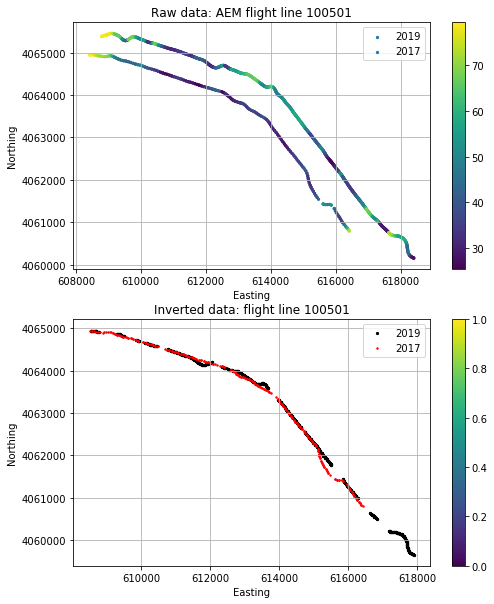

In [86]:
line = 100501
f,axs = plt.subplots(2,1,figsize=(8,10))
plt.sca(axs.flatten()[0])
ax = plt.gca()
plt.scatter(df.loc[np.logical_and(df.LINE_NO==line,df.skytem_type==312),'UTMX']+500,
            df.loc[np.logical_and(df.LINE_NO==line,df.skytem_type==312),'UTMY']+500,
            s=5,
            c=df.loc[np.logical_and(df.LINE_NO==line,df.skytem_type==312),'INVALT'],
            label='2019')

plt.scatter(df.loc[np.logical_and(df.LINE_NO==line,df.skytem_type==304),'UTMX'],
            df.loc[np.logical_and(df.LINE_NO==line,df.skytem_type==304),'UTMY'],
            s=5,
            c=df.loc[np.logical_and(df.LINE_NO==line,df.skytem_type==304),'INVALT'],
            label='2017')


plt.grid(True)
plt.colorbar()
plt.legend()
plt.xlabel('Easting')
plt.ylabel('Northing')
plt.title('Raw data: AEM flight line {}'.format(line))



plt.sca(axs.flatten()[1])
ax = plt.gca()
plt.scatter(df19.loc[df19.LINE==line,'X'],
            df19.loc[df19.LINE==line,'Y'],
            s=5,
            c='k',
            label='2019')
plt.scatter(df17.loc[df17.LINE==line,'X'],
            df17.loc[df17.LINE==line,'Y'],
            s=2,
            c='r',
            label='2017')

# plt.scatter(df19.loc[df19.LINE==line,'X'],df19.loc[df19.LINE==line,'Y'],s=1,c='k',label='2019')
plt.grid(True)
plt.colorbar()
plt.legend()
plt.xlabel('Easting')
plt.ylabel('Northing')
plt.title('Inverted data: flight line {}'.format(line))